In [6]:
import torch
import os

In [1]:

model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


In [3]:
import numpy as np

In [4]:
import torch.nn as nn
import matplotlib.pyplot as plt

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def plot_layer_heads(attention, num_layers=12, num_heads=12):
  for i in range(0,11):
    p = attention[i]
    fig, axis = plt.subplots(1,12, figsize=(20,5), facecolor='w', edgecolor='k')
    plt.title(f'layer {i}')
    head = 0
    for axs, ph in zip(axis.flatten(), p):
      heatmap = axs.imshow(ph, cmap='hot')
    
# create (1, 3, 384, 384) shape 
def make_example(image):
    example_channel = np.expand_dims(image, axis=0)
    batch = np.append(example_channel, example_channel, axis=0)
    batch = np.append(batch, example_channel, axis=0)
    example_3channel = np.expand_dims(batch, axis=0)
    return example_3channel

In [4]:
#test run of barlow twins minus the linear last layer
model.fc = Identity()
x = torch.randn(1, 3, 384, 384)
output = model(x)
print(output.shape)

torch.Size([1, 2048])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
x[0][0][0][0]

tensor(-0.1420)

In [8]:
output_dir='/tf/notebooks/QA_attentions_pickled'

In [9]:
scaled_attentions = torch.load(os.path.join(output_dir, "scaled_attentions_100.bin"))

In [11]:
torch.from_numpy(scaled_attentions[99][0][0]).shape

torch.Size([384, 384])

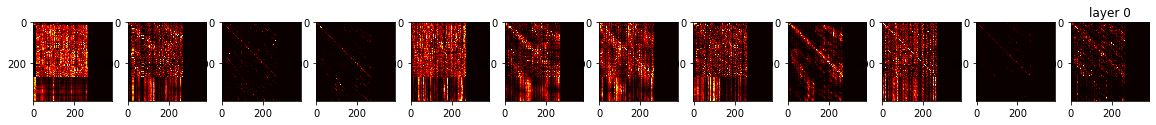

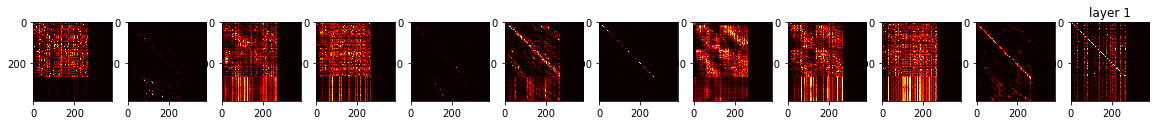

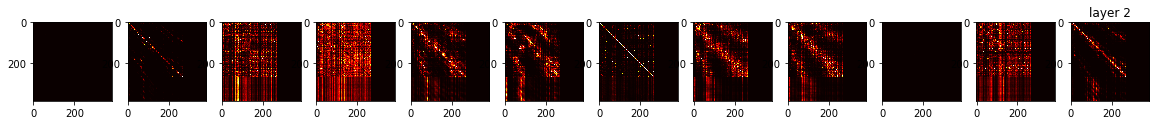

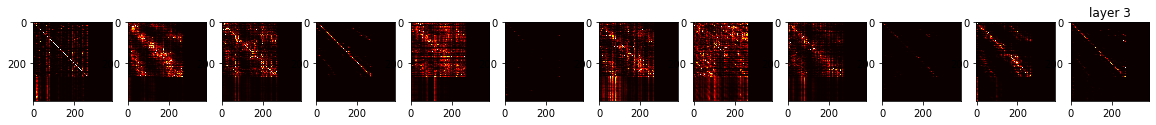

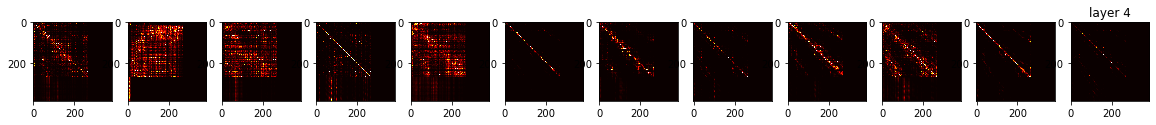

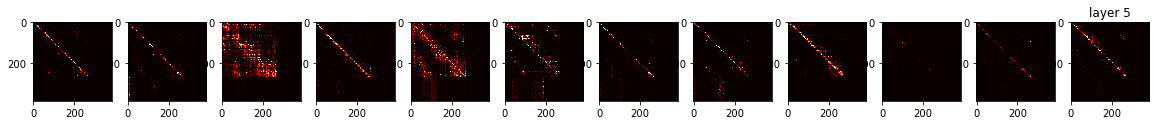

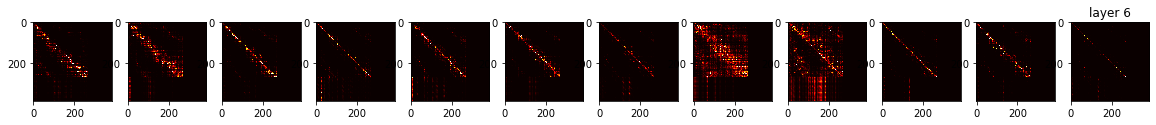

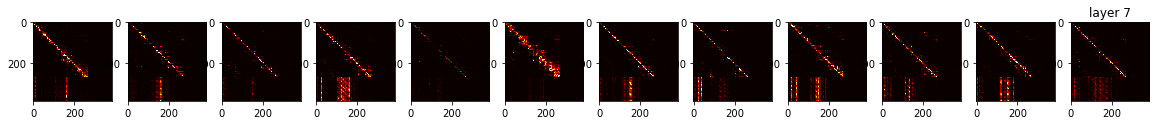

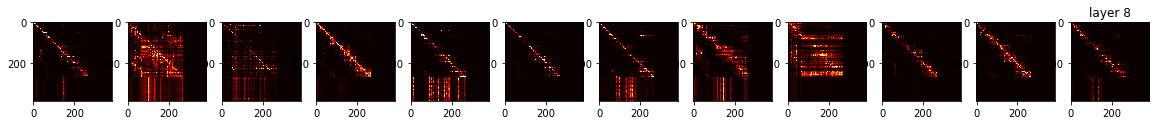

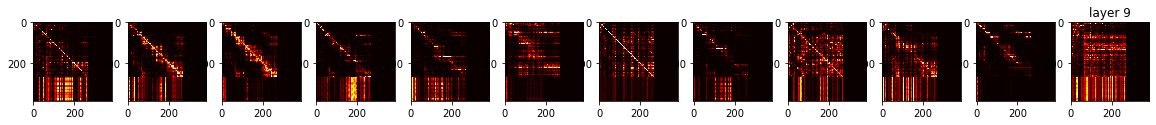

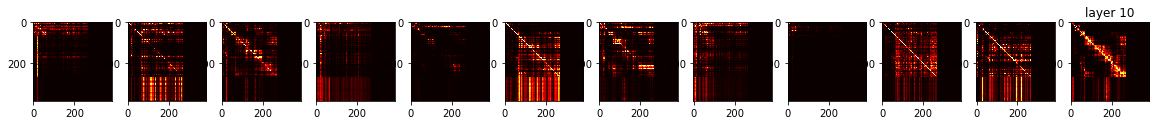

In [17]:
plot_layer_heads(scaled_attentions[99])

In [12]:
image = scaled_attentions[99][0][0]
image[0]

array([ 76,  37,  20,  39,  17,  10,  31,  16,  75,  79,  63,  77,  24,
        47,  47, 157, 193, 194,  87, 144,  71,  75, 254,  78, 254,  66,
        66,  72, 168,  38, 153, 153,  13, 186, 121,  34,  46,  49,  14,
        59,  71,  18,  75, 180,  43, 109, 122,  70, 126, 116,  60, 108,
       158, 124,  87,  57,  70,  13,  43, 105,  86, 128, 111, 112,  41,
        69, 122, 143,  47,  60, 115,  55,  78,  36, 128,  26,  80,  86,
       129,  31,  52,   8,  62, 239, 254, 214, 160, 180,  25,  73, 101,
       101,  54, 115,  45,  61,  25,  59, 253,  52,  67,  83,  60,  48,
       106,  17,  62,  82,  50,  30,  64,  73,  95, 254,  94,  25,  62,
       111,  41,  19, 254,  41,  77,  89, 168,  64,  95,   9,  22, 111,
        11,  33,  10, 119,  18,  72,  37,  68,  57,  58,  17,  25,   9,
        14,  45,  17,  10,  18,  47,   7,  67,  16,  21,   8,  77,  13,
        23,  38,  48,  12,   7,  70,  58,  23,  56,  80,  13,  19,  54,
       117, 154,  89,  47,  43,  38,  16,  45,   5,  79,  26, 11

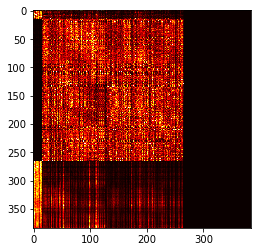

In [45]:
plt.imshow(image, cmap='hot', interpolation='nearest')

In [18]:
torch.from_numpy(image).shape

(384, 384)

In [95]:
image = scaled_attentions[99][0][0]

In [96]:
(make_example(image)).shape

(1, 3, 384, 384)

In [101]:
example_attention = scaled_attentions[99]
head0_layer0 = example_attention[0][0]
head1_layer0 = example_attention[0][1]
head2_layer0 = example_attention[0][2]

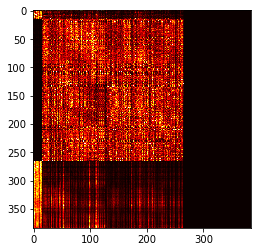

In [137]:
plt.imshow(head0_layer0, cmap='hot', interpolation='nearest')

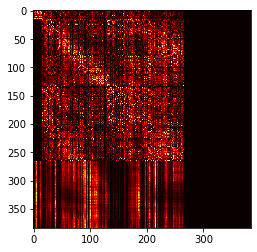

In [138]:
plt.imshow(head1_layer0, cmap='hot', interpolation='nearest')

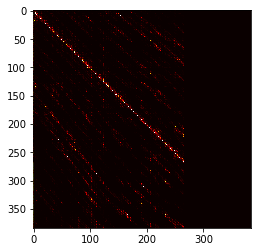

In [139]:
plt.imshow(head2_layer0, cmap='hot', interpolation='nearest')

In [145]:
reshaped_head0 = torch.from_numpy(make_example(head0_layer0))
reshaped_head1 = torch.from_numpy(make_example(head1_layer0))
reshaped_head2 = torch.from_numpy(make_example(head2_layer0))

In [148]:
reshaped_head1[0][0][0][0]

tensor(144, dtype=torch.int32)

In [149]:
representation_head0 = model(reshaped_head0.float())
representation_head1 = model(reshaped_head1.float())
representation_head2 = model(reshaped_head2.float())

In [150]:
representation_head0[0]

tensor([0.0082, 0.0202, 0.0133,  ..., 0.0395, 0.0018, 0.0121],
       grad_fn=<SelectBackward>)

In [151]:
representation_head2[0]

tensor([0.0008, 0.0163, 0.0163,  ..., 0.0034, 0.0201, 0.0343],
       grad_fn=<SelectBackward>)

In [165]:
zero_one = abs(representation_head0 - representation_head1)

In [169]:
one_two = abs(representation_head1 - representation_head2)

In [170]:
zero_two = abs(representation_head0 - representation_head2)

In [171]:
zero_one < one_two

tensor([[ True,  True, False,  ..., False,  True,  True]])

In [49]:
import time

In [11]:
start_time = time.time()

barlow_representations = np.zeros((100), np.object)
for i, example in enumerate(scaled_attentions):
    reshaped_example = np.zeros((12,12), np.object)
    for l, layer in enumerate(example):
        for h, head in enumerate(layer):
            reshaped_head = torch.from_numpy(make_example(head))
            representation_head = model(reshaped_head.float())
            reshaped_example[l][h] = representation_head.detach().cpu().numpy()
    barlow_representations[i] = reshaped_example


print("--- %s seconds ---" % (time.time() - start_time))

--- 1319.8736515045166 seconds ---


In [15]:
start_time = time.time()

cuda = torch.device('cuda:0')
model.to(cuda)

barlow_representations = np.zeros((100), np.object)
for i, example in enumerate(scaled_attentions):
    reshaped_example = np.zeros((12,12), np.object)
    for l, layer in enumerate(example):
        for h, head in enumerate(layer):
            reshaped_head = torch.from_numpy(make_example(head)).to(cuda)
            representation_head = model(reshaped_head.float())
            reshaped_example[l][h] = representation_head.detach().cpu().numpy()
    barlow_representations[i] = reshaped_example


print("--- %s seconds ---" % (time.time() - start_time))

--- 160.1530966758728 seconds ---


In [16]:
barlow_representations[99][11][11].shape

(1, 2048)

In [17]:
barlow_representations[99][11][11]

array([[0.02067391, 0.01267529, 0.01239547, ..., 0.        , 0.00014754,
        0.02295655]], dtype=float32)

In [18]:
torch.save(barlow_representations, os.path.join(output_dir, "representation_100_test.bin"))

In [10]:
barlow_representations = torch.load(os.path.join(output_dir, "representation_100_test.bin"))

In [20]:
#!pip install hdbscan

     |████████████████████████████████| 6.4 MB 2.8 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached Cython-0.29.23-cp36-cp36m-manylinux1_x86_64.whl (2.0 MB)
     |████████████████████████████████| 22.2 MB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 63.6 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 25.2 MB/s eta 0:00:01
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp36-cp36m-linux_x86_64.whl size=2311392 sha256=c19471f4bae900c5b65909a2345ad16f90339b382526729f5bc683b4feb58682
  Stored in directory: /root/.cache/pip/wheels/70/52/fe/83ef5a0e879c48df9968d931d41046226e4cb19a166f0223d2
Successfully built hdbscan
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import hdbscan

In [12]:
len(barlow_representations[0][0][0])

1

In [13]:
flat_barlow_examples = np.zeros((14400), np.ndarray)
i = 0
for example in barlow_representations:
    for layer in example:
        for h, head in enumerate(layer):
            flat_barlow_examples[i] = head[0]
            i += 1

In [14]:
len(flat_barlow_examples)



14400

In [70]:
!pip install pandas

     |████████████████████████████████| 9.5 MB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 17.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [30]:
pip install seaborn

     |████████████████████████████████| 285 kB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import seaborn as sns

In [15]:
import pandas as pd

In [16]:
df = pd.DataFrame(flat_barlow_examples)

In [17]:
df_b = pd.DataFrame([pd.Series(x) for x in df[0]])

In [25]:
df_b

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.002285,0.023679,0.001289,0.020123,0.025710,0.000000,0.031131,0.123703,0.008722,0.017678,...,0.054443,0.023007,0.013160,0.097280,0.000000,0.024212,0.003148,0.024161,0.003252,0.008743
1,0.000834,0.008564,0.083909,0.024400,0.029728,0.000000,0.030568,0.099845,0.000152,0.007008,...,0.017309,0.006072,0.017078,0.073935,0.000141,0.023905,0.000000,0.001089,0.010439,0.030878
2,0.009980,0.009717,0.004832,0.027625,0.041831,0.000000,0.051989,0.040908,0.000000,0.000731,...,0.030333,0.012205,0.011397,0.067697,0.003594,0.019141,0.004597,0.013598,0.003650,0.017372
3,0.004172,0.004604,0.008703,0.036752,0.082471,0.000747,0.008365,0.047674,0.024708,0.012520,...,0.037167,0.000000,0.002994,0.068880,0.005776,0.039645,0.000917,0.006456,0.004488,0.021322
4,0.000873,0.079560,0.035619,0.049800,0.005700,0.004468,0.038469,0.042218,0.000570,0.018004,...,0.028795,0.040768,0.024805,0.077981,0.020556,0.008355,0.010079,0.051801,0.000208,0.007705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,0.006802,0.012926,0.008110,0.026512,0.010556,0.005068,0.009910,0.039416,0.000000,0.012427,...,0.003585,0.015268,0.004977,0.126391,0.021651,0.035742,0.006618,0.002131,0.004639,0.008845
14396,0.017738,0.033293,0.005914,0.026218,0.025399,0.004692,0.010112,0.121597,0.006607,0.041155,...,0.007546,0.007800,0.033731,0.142834,0.024379,0.037948,0.006296,0.030895,0.014695,0.005363
14397,0.021870,0.027752,0.024590,0.017234,0.008362,0.001826,0.016834,0.046415,0.015610,0.035355,...,0.005821,0.017858,0.043207,0.114705,0.005684,0.040695,0.003432,0.002589,0.039683,0.030542
14398,0.007847,0.011713,0.018304,0.019529,0.006018,0.006761,0.014316,0.071214,0.015645,0.012348,...,0.001607,0.014693,0.052502,0.116006,0.013273,0.048257,0.004814,0.000000,0.017470,0.027438


In [23]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=60,
    min_samples = 20,
    core_dist_n_jobs=16)

In [24]:
clusterer.fit(df_b)

HDBSCAN(core_dist_n_jobs=16, min_cluster_size=60, min_samples=20)

<AxesSubplot:ylabel='$\\lambda$ value'>

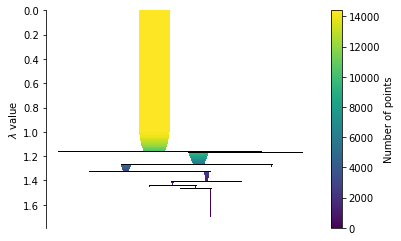

In [27]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

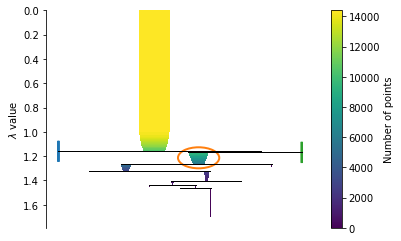

In [32]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

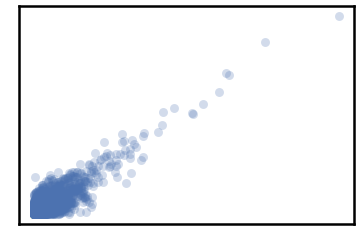

In [42]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.scatter(df_b.T[1001], df_b.T[2002], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [51]:
clusterer.labels_

array([ 0,  1,  1, ..., -1, -1, -1])

In [52]:
df_labels = pd.DataFrame(clusterer.labels_)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

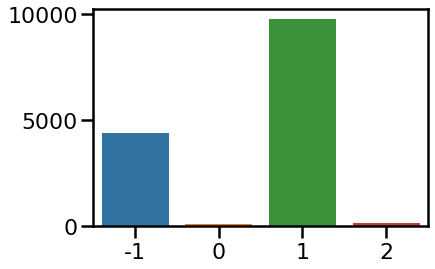

In [54]:
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [47]:
rating_count

 1    9772
-1    4397
 2     143
 0      88
Name: 0, dtype: int64

In [55]:
start_time = time.time()
clusterer2 = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples = 5,
    core_dist_n_jobs=16)
clusterer2.fit(df_b)
print("--- %s seconds ---" % (time.time() - start_time))

--- 727.0945596694946 seconds ---


<AxesSubplot:ylabel='$\\lambda$ value'>

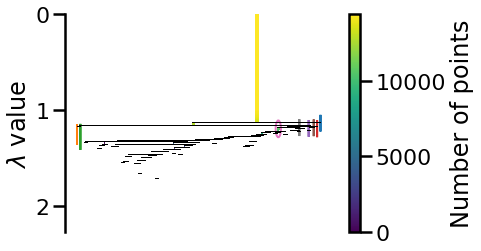

In [56]:
clusterer2.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

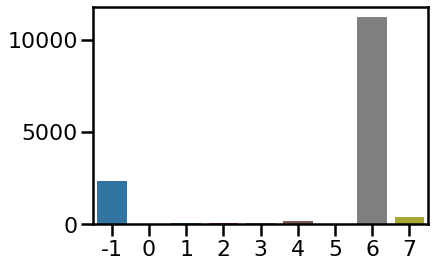

In [57]:
df_labels = pd.DataFrame(clusterer2.labels_)
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [87]:
df_labels[df_labels[0] == 6].head(26)

,0
1,6
2,6
3,6
4,6
5,6
6,6
7,6
8,6
9,6
10,6


In [59]:
14400/100

144.0

In [66]:
2161/144

15.027777777777779

In [76]:
2180 % 144

20

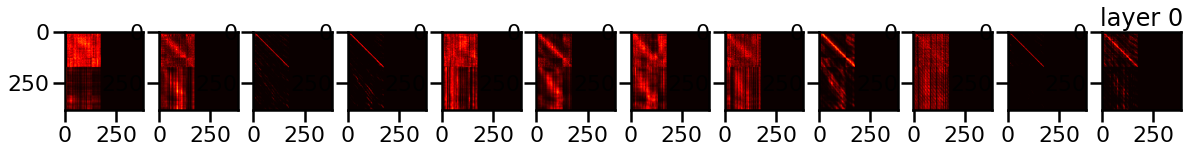

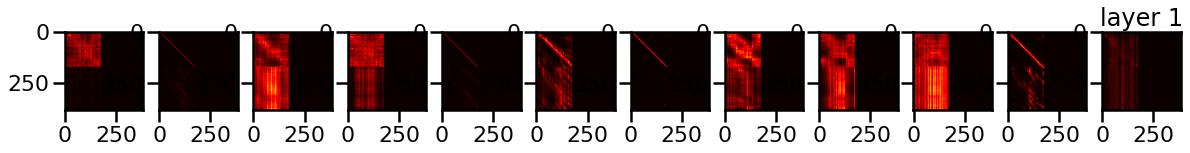

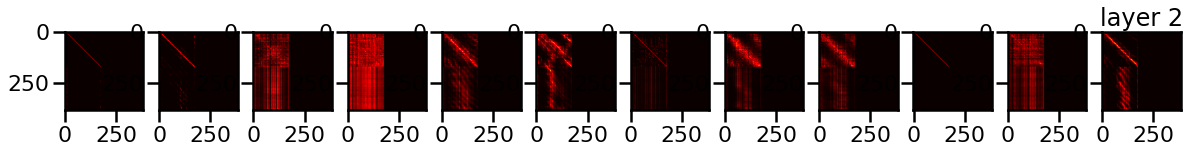

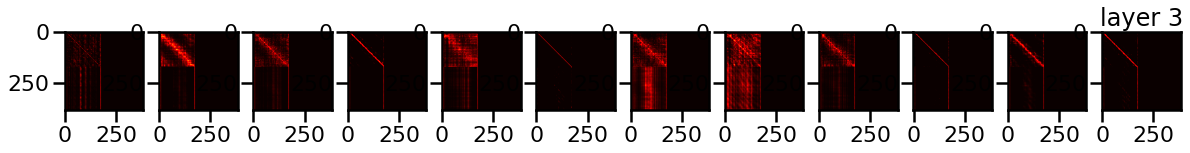

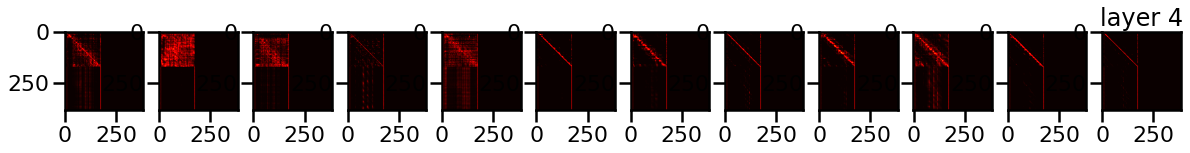

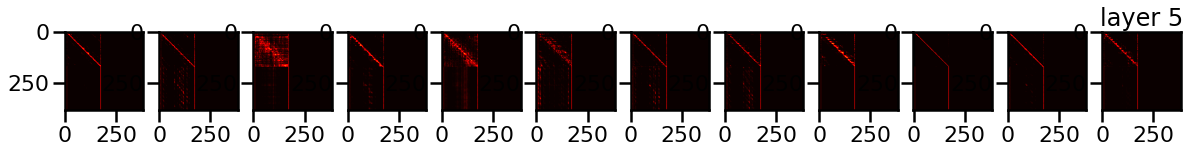

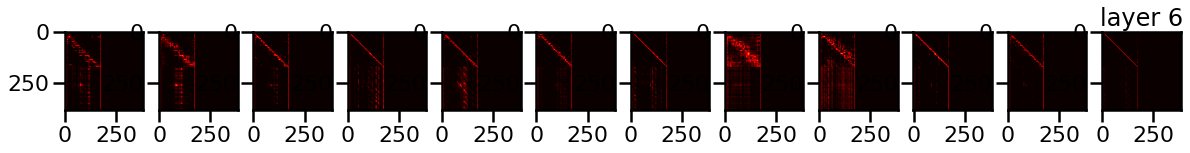

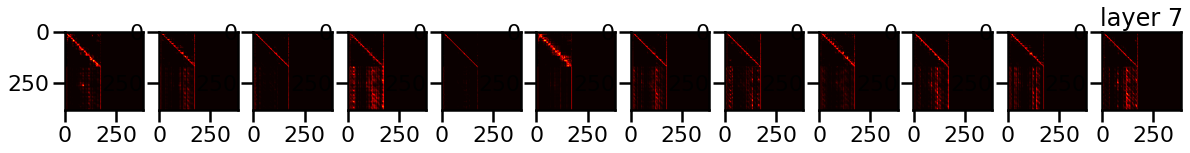

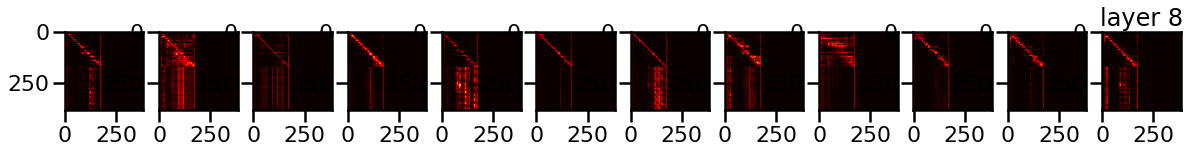

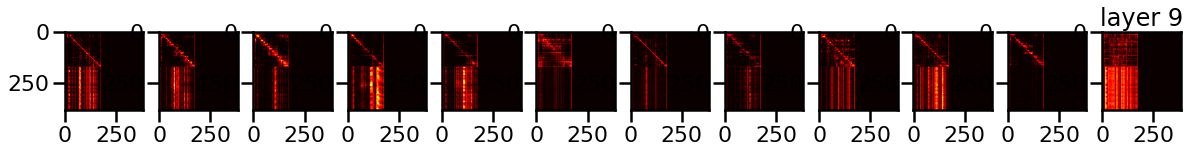

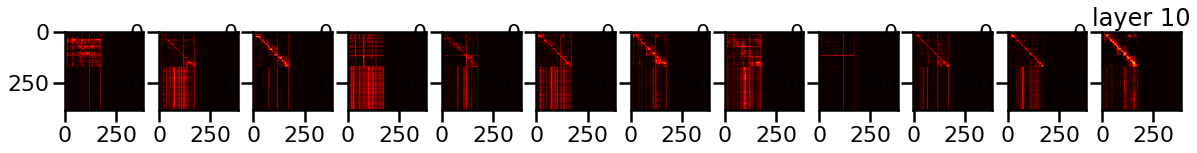

In [86]:
plot_layer_heads(scaled_attentions[0])

In [90]:
start_time = time.time()
clusterer2 = hdbscan.HDBSCAN(
    metric="manhattan",
    min_cluster_size=40,
    min_samples = 20,
    core_dist_n_jobs=16)
clusterer2.fit(df_b)
print("--- %s seconds ---" % (time.time() - start_time))

--- 729.1382730007172 seconds ---


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

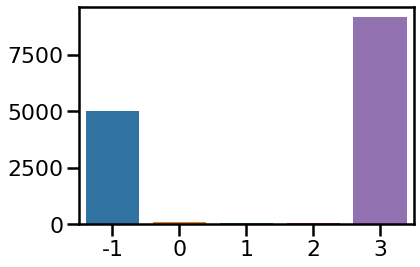

In [95]:
df_labels = pd.DataFrame(clusterer2.labels_)
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [96]:
rating_count.values

array([9170, 5036,   94,   51,   49])

In [101]:
start_time = time.time()
clusterer3 = hdbscan.HDBSCAN(
    metric="manhattan",
    min_cluster_size=100,
    min_samples = 20,
    core_dist_n_jobs=16)
clusterer3.fit(df_b)
print("--- %s seconds ---" % (time.time() - start_time))

--- 727.9971811771393 seconds ---


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

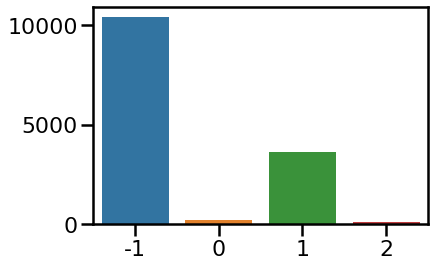

In [102]:
df_labels = pd.DataFrame(clusterer3.labels_)
rating_count = df_labels[0].value_counts()

x = rating_count.index
y = rating_count.values

sns.barplot(x, y)

In [103]:
rating_count.values

array([10407,  3634,   226,   133])